## import packages

In [1]:
from Utils.Models import *
from Utils.Densenet import *
from ultralytics import YOLO

2024-04-14 14:12:05.800791: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## YOLO

### load model

In [2]:
yolo_model_dir = "/home/jiajianhao/文档/cnn/my_Magnetic_methods-master/YOLOv8/my_Model_training/runs/detect/4000data/weights/best.pt"
model = YOLO(yolo_model_dir)

### predict my data

In [3]:
yolo_prd_dir = "data/4000_with_noise/test"
yolo_results = model.predict(source=yolo_prd_dir, save=True, save_txt=True,iou=0.3)


image 1/200 /home/jiajianhao/文档/cnn/my_Magnetic_methods-master/data/4000_with_noise/test/test_1.jpg: 640x640 2 ellipsoids, 15.3ms
image 2/200 /home/jiajianhao/文档/cnn/my_Magnetic_methods-master/data/4000_with_noise/test/test_10.jpg: 640x640 1 ellipsoid, 14.2ms
image 3/200 /home/jiajianhao/文档/cnn/my_Magnetic_methods-master/data/4000_with_noise/test/test_100.jpg: 640x640 1 dipole, 7 ellipsoids, 10.8ms
image 4/200 /home/jiajianhao/文档/cnn/my_Magnetic_methods-master/data/4000_with_noise/test/test_101.jpg: 640x640 1 dipole, 2 ellipsoids, 9.5ms
image 5/200 /home/jiajianhao/文档/cnn/my_Magnetic_methods-master/data/4000_with_noise/test/test_102.jpg: 640x640 5 ellipsoids, 9.0ms
image 6/200 /home/jiajianhao/文档/cnn/my_Magnetic_methods-master/data/4000_with_noise/test/test_103.jpg: 640x640 1 dipole, 2 ellipsoids, 8.3ms
image 7/200 /home/jiajianhao/文档/cnn/my_Magnetic_methods-master/data/4000_with_noise/test/test_104.jpg: 640x640 1 dipole, 3 ellipsoids, 8.0ms
image 8/200 /home/jiajianhao/文档/cnn/my_Magn

### split all data into one model(dip or ellipsoid) with parameter

In [ ]:
for r in yolo_results:
    boxes = r.boxes  # Boxes object for bbox outputs
    masks = r.masks  # Masks object for segment masks outputs
    probs = r.probs  # Class probabilities for classification outputs

## DenseNet

### 导入模型

In [2]:
load_path = 'content/my_Densenet_par_9_TL_dipoles.hdf5'

best_model = load_model(load_path, custom_objects={'r2': r2})
best_model.summary()
best_model.compile(optimizer = Adam(learning_rate = 1e-5), 
              loss= MSE,
              metrics= [r2])

2024-04-14 14:12:19.135022: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-04-14 14:12:19.135213: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-04-14 14:12:19.164653: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.89GiB deviceMemoryBandwidth: 681.88GiB/s
2024-04-14 14:12:19.164931: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:03:00.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.89GiB deviceMemoryBandwidth: 681.88GiB/s
2024-04-14 14:12:19.164972: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

### 预测

In [3]:
read_dir = '/home/jiajianhao/文档/cnn/my_Magnetic_methods-master/data/densnet/init'
parameter, num_of_dipoles,kind_of_data, bbox,data,gass_id,n_of_each = read_data(read_dir,'parameter', 'num_of_dipoles','kind_of_data', 'bbox','data','gass_id','n_of_each')

In [4]:
den_data = cov_to_densenet(parameter, num_of_dipoles, bbox,data)
data,para = fliter_acdt_type(n_of_each, parameter, num_of_dipoles,den_data, kind_of_data)
den_data.shape

(4000, 9, 64, 64)

In [6]:
dipole_data,ellipse_data = data['0'],data['1']
dipole_para,ellipse_para = para['0'],para['1']

In [7]:
dipole_data_img = gray_to_rgb(dipole_data)
ellipse_data_img = gray_to_rgb(ellipse_data)

In [8]:
train_data, train_para, val_data, val_para, test_data, test_para = split_data(dipole_data_img,dipole_para)
test_data.shape

(274, 64, 64, 3)

In [9]:
# 仅使用深度和半径参数
train_para,val_para,test_para = para_select(2,4,train_para,val_para,test_para)

In [10]:
####### Predicting test set ##########

Parameters_predictions_norm = best_model.predict(test_data, verbose=0)



Parameters_predictions_norm[:,0] = np.round(Parameters_predictions_norm[:,0], decimals = 1)
Parameters_predictions_norm[:,1] = np.round(Parameters_predictions_norm[:,1], decimals = 1)
#Parameters_predictions_norm[:,2] = np.round(Parameters_predictions_norm[:,2], decimals = 1)


2024-04-14 14:17:00.507737: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-04-14 14:17:00.508493: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499780000 Hz
2024-04-14 14:17:01.171240: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-04-14 14:17:01.371880: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


[        1.4        0.12]
[        1.4         0.1]


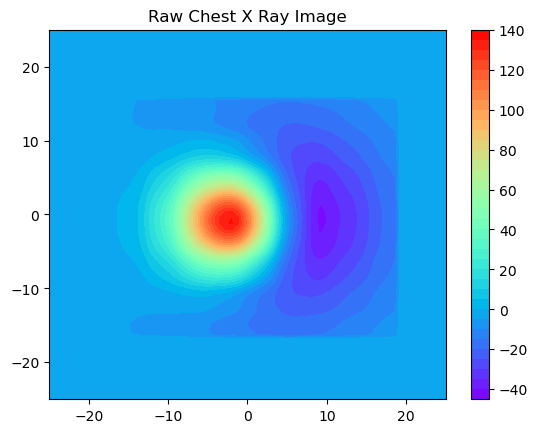

In [83]:
nn = np.random.randint(test_data.shape[0])

zmax= 64

conversion = (25*2)/zmax
map_lenght = 25

xmin = -map_lenght
xmax = map_lenght
ymin = -map_lenght
ymax = map_lenght

X = np.linspace(xmin, xmax, zmax)
Y = np.linspace(ymin, ymax, zmax)
sample_img = test_data[nn,:,:,0]
plt.contourf(X, Y, sample_img, levels = 40, cmap='rainbow')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(test_para[nn])
print(Parameters_predictions_norm[nn])


In [85]:
#Volume_real = np.around(Volume_predictions, decimals=2)
r_real = test_para[:,0]

#Depth_real = np.around(Y_test_params[:,5:10], decimals=2)
Depth_real = test_para[:,1]
#Volume_real = np.around(Volume_predictions, decimals=2)
r_predicted = Parameters_predictions_norm[:,0]

#Depth_real = np.around(Y_test_params[:,5:10], decimals=2)
Depth_predicted = Parameters_predictions_norm[:,1]

/share/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/share/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/share/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/share/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

<Axes: >

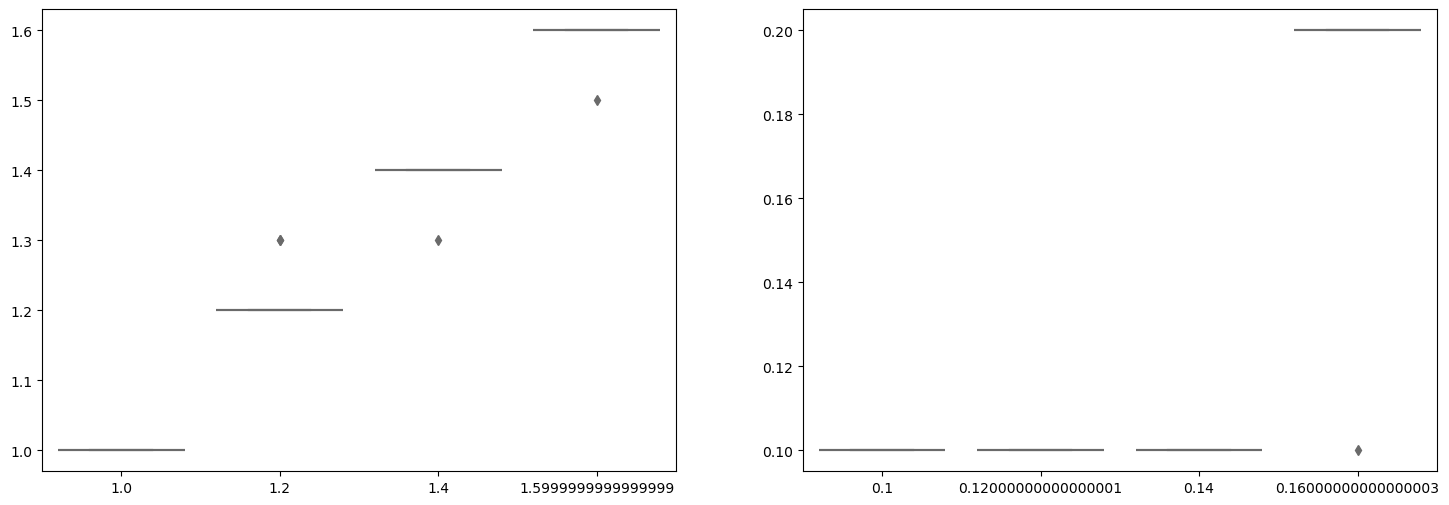

In [86]:
# Box plot visualization 

fig, ax = plt.subplots(1, 2, figsize=(18,6))

sns.set(style="whitegrid")

sns.boxplot(x=r_real[:], y=r_predicted[:], palette="Set3", ax=ax[0])

sns.boxplot(x=Depth_real[:], y=Depth_predicted[:], palette="Set3", ax=ax[1])


## other Net